In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from tqdm import tqdm

import mne

from scipy.signal import iirnotch, butter, filtfilt
from scipy.stats import pearsonr

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

FILE_PATH = Path('MindBigData2022_MNIST_EP')

# Utility functions

In [2]:
def plot_eeg_sample(eeg_sample, channels, title="EEG Sample", figsize=(15, 10)):
    """
    Plots one EEG sample (shape: [channels, timepoints]) with beautiful formatting.
    
    Parameters:
    - eeg_sample: np.array of shape (channels, timepoints)
    - channels: list of channel names
    - title: title of the plot
    - figsize: figure size
    """
    num_channels, num_timepoints = eeg_sample.shape
    
    fig, axes = plt.subplots(num_channels, 1, figsize=figsize, sharex=True)
    fig.suptitle(title, fontsize=18)
    
    time = range(num_timepoints)
    
    for i in range(num_channels):
        ax = axes[i]
        ax.plot(time, eeg_sample[i], linewidth=1)
        ax.set_ylabel(channels[i], rotation=0, labelpad=40, fontsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('gray')
        ax.spines['bottom'].set_color('gray')
        ax.tick_params(axis='y', labelsize=8)
        ax.tick_params(axis='x', labelsize=8)
    
    axes[-1].set_xlabel("Time (samples)", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Reading Data

In [3]:
train_df = pd.read_csv(FILE_PATH / "train.csv")
test_df = pd.read_csv(FILE_PATH / "test.csv")

# Dataset Checks

In [4]:
def get_unique_channels(cols):
    """
    Get unique channels from the DataFrame.
    """
    unique_channels = []
    for col in cols:
            channel = col.split('-')[0]
            if channel not in unique_channels:
                unique_channels.append(channel)
    
    return unique_channels

def extract_channel_indexes(cols):
    channel_indexes = {}

    for col in cols:
        channel = col.split('-')[0]
        num = col.split('-')[1]
        if channel not in channel_indexes:
            channel_indexes[channel] = []
        channel_indexes[channel].append(num)

    return channel_indexes

Test set

In [5]:
eeg_feature_cols = [i for i in test_df.columns if i != 'label']
unique_channels = get_unique_channels(eeg_feature_cols)
channel_indexes = extract_channel_indexes(eeg_feature_cols)
channel_length = {channel:len(indexes) for channel, indexes in channel_indexes.items()}
channel_consistency = all(len(indexes) == len(channel_indexes[unique_channels[0]]) for indexes in channel_indexes.values())

print(f"Unique Channels: {unique_channels}")
print(f"Unique Channels Length: {channel_length}")
print(f"Channel Consistency: {channel_consistency}")


Unique Channels: ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
Unique Channels Length: {'AF3': 256, 'F7': 256, 'F3': 256, 'FC5': 256, 'T7': 256, 'P7': 256, 'O1': 256, 'O2': 256, 'P8': 256, 'T8': 256, 'FC6': 256, 'F4': 256, 'F8': 256, 'AF4': 256}
Channel Consistency: True


Train set

In [6]:
eeg_feature_cols = [i for i in train_df.columns if i != 'label']
unique_channels = get_unique_channels(eeg_feature_cols)
channel_indexes = extract_channel_indexes(eeg_feature_cols)
channel_length = {channel:len(indexes) for channel, indexes in channel_indexes.items()}
channel_consistency = all(len(indexes) == len(channel_indexes[unique_channels[0]]) for indexes in channel_indexes.values())

print(f"Unique Channels: {unique_channels}")
print(f"Unique Channels Length: {channel_length}")
print(f"Channel Consistency: {channel_consistency}")


Unique Channels: ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
Unique Channels Length: {'AF3': 256, 'F7': 256, 'F3': 256, 'FC5': 256, 'T7': 256, 'P7': 256, 'O1': 256, 'O2': 256, 'P8': 256, 'T8': 256, 'FC6': 256, 'F4': 256, 'F8': 256, 'AF4': 256}
Channel Consistency: True


# Constructing a dataset

In [37]:
def create_eeg_dataset(df):
    # Extract labels
    df = df[df['label'].isin([0, 1])]  # Remove rows with label -1

    # df['label'] = df['label'].replace({0: 0, -1: 1})  # Replace -1 with 1 for binary classification

    y = df['label'].values

    eeg_df = df.drop(columns=['label'])

    # Parameters
    channels = sorted(set(col.split('-')[0] for col in eeg_df.columns))  # 14 channels
    num_channels = len(channels)
    num_timepoints = sum(1 for col in eeg_df.columns if col.startswith(channels[0]))  # e.g., 256

    # Convert to numpy and reshape
    X = eeg_df.values.reshape(-1, num_channels, num_timepoints)  # (N samples, 14 channels, 256 timepoints)

    return X, y

def apply_notch_filter(data, fs=256, notch_freq=50.0, bandwidth=1.0):
    Q = notch_freq / bandwidth
    b, a = iirnotch(notch_freq, Q, fs)
    return filtfilt(b, a, data)

def apply_bandpass_filter(data, fs=256, lowcut=0.4, highcut=60.0, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def mne_reject_bad_epochs(X, y, ch_names, sfreq=256, threshold_uv=100.0, verbose=True):
    """
    Use MNE to reject epochs (samples) with artifacts exceeding 100 µV peak-to-peak.
    
    Parameters:
    - X: (N, C, T) EEG data in microvolts
    - y: (N,) labels
    - ch_names: list of channel names, length = C
    - sfreq: sampling rate in Hz
    - threshold_uv: rejection threshold in microvolts

    Returns:
    - X_clean: (N_clean, C, T)
    - y_clean: (N_clean,)
    """
    N, C, T = X.shape

    # Define MNE info
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    
    # Convert data from µV to V (MNE expects volts)
    X_volts = X / 1e6

    # Create EpochsArray
    epochs = mne.EpochsArray(X_volts, info, verbose=verbose)

    # Apply artifact rejection based on peak-to-peak threshold
    reject_criteria = dict(eeg=threshold_uv * 1e-6)  # convert µV to V
    epochs.drop_bad(reject=reject_criteria)

    # Extract cleaned data
    X_clean = epochs.get_data() * 1e6  # convert back to µV
    y_clean = y[epochs.selection]     # keep only surviving labels

    return X_clean, y_clean

def erp_denoise_by_class_channel(X, y, threshold=0.9, verbose=True):
    """
    Remove noisy samples based on ERP correlation per class and channel.

    Parameters:
    - X: np.ndarray of shape (N, C, T)
    - y: np.ndarray of shape (N,)
    - threshold: correlation threshold (e.g. 0.9)
    - verbose: show progress bar

    Returns:
    - X_clean: (N_clean, C, T)
    - y_clean: (N_clean,)
    - retained_mask: list of bools (length N), True if sample kept
    """
    N, C, T = X.shape
    classes = np.unique(y)
    retained = np.zeros(N, dtype=bool)  # mask for final selected samples

    # Index samples per class
    class_indices = {cls: np.where(y == cls)[0] for cls in classes}

    for cls in tqdm(classes, desc="ERP Denoising", disable=not verbose):
        idx_cls = class_indices[cls]
        X_cls = X[idx_cls]  # shape (n_cls, C, T)

        for ch in range(C):
            # Extract all signals for this class and channel
            channel_signals = X_cls[:, ch, :]  # shape (n_cls, T)

            # Compute ERP (mean signal)
            erp = channel_signals.mean(axis=0)

            # Compute correlation per sample
            for i_local, x in enumerate(channel_signals):
                rho, _ = pearsonr(x, erp)
                if rho > threshold:
                    i_global = idx_cls[i_local]
                    retained[i_global] = True

    # Apply retained mask to data
    X_clean = X[retained]
    y_clean = y[retained]
    return X_clean, y_clean

def filter_dataset(X, fs=256, verbose=True):
    """
    Apply notch and bandpass filters to EEG dataset.
    Returns filtered data in µV, same shape as input.
    """
    X_filtered = []

    for i in tqdm(range(len(X)), desc="Filtering") if verbose else range(len(X)):
        sample = X[i]
        sample = apply_notch_filter(sample, fs)
        sample = apply_bandpass_filter(sample, fs)
        X_filtered.append(sample)

    return np.stack(X_filtered)

def full_preprocessing_pipeline(X, y, ch_names, fs=256, verbose=True):
    """
    Full preprocessing pipeline:
    1. Filtering (Notch + Bandpass)
    2. Artifact rejection (MNE, 100 µV threshold)
    3. Classwise CAR with correlation-based channel selection
    """
    # Step 1: Filtering
    X_filtered = filter_dataset(X, fs=fs, verbose=verbose)

    # Step 2: MNE artifact rejection
    X_clean, y_clean = mne_reject_bad_epochs(X_filtered, y, ch_names, sfreq=fs, threshold_uv=100.0, verbose=verbose)

    # Step 3: Classwise CAR + correlation mask
    X_final, y_final = erp_denoise_by_class_channel(X_clean, y_clean, threshold=0.7, verbose=verbose)

    return X_final, y_final

In [38]:
X_test, y_test = create_eeg_dataset(test_df)
X_train, y_train = create_eeg_dataset(train_df)

In [41]:
X_train_processed, y_train_processed = full_preprocessing_pipeline(X_train, y_train, fs=128, verbose=True, ch_names=unique_channels)
X_test_processed, y_test_processed = full_preprocessing_pipeline(X_test, y_test, fs=128, verbose=True, ch_names=unique_channels)

Filtering: 100%|██████████| 10292/10292 [00:04<00:00, 2277.26it/s]


Not setting metadata
10292 matching events found
No baseline correction applied
0 projection items activated
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FC6', 'F8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC6', 'F4', 'F8', 'AF4']
    Rejecting  epoch based on EEG : ['FC5', 'T7']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['AF3', 'F8', 'AF4']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF3', 'T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF3']
  

ERP Denoising: 100%|██████████| 2/2 [01:24<00:00, 42.32s/it]


In [42]:
print(f"Shape comparison before and after preprocessing: {X_train.shape} -> {X_train_processed.shape}")
print(f"Shape comparison before and after preprocessing: {X_test.shape} -> {X_test_processed.shape}")

Shape comparison before and after preprocessing: (10292, 14, 256) -> (166, 14, 256)
Shape comparison before and after preprocessing: (2575, 14, 256) -> (35, 14, 256)


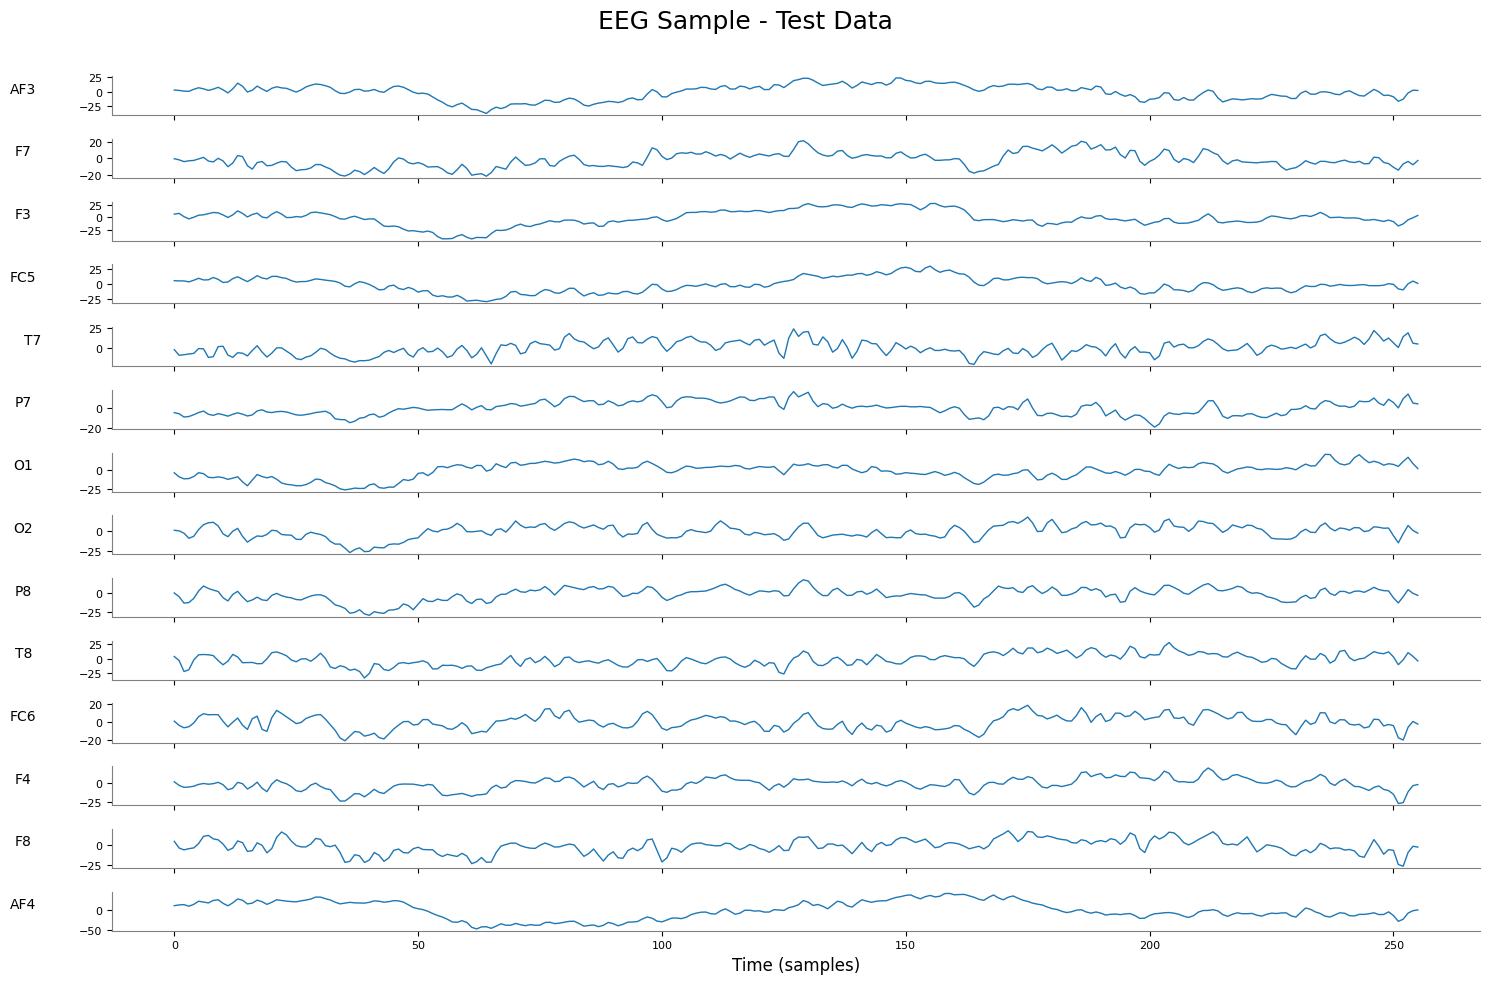

In [45]:
plot_eeg_sample(X_test_processed[0], channels=unique_channels, title="EEG Sample - Test Data")

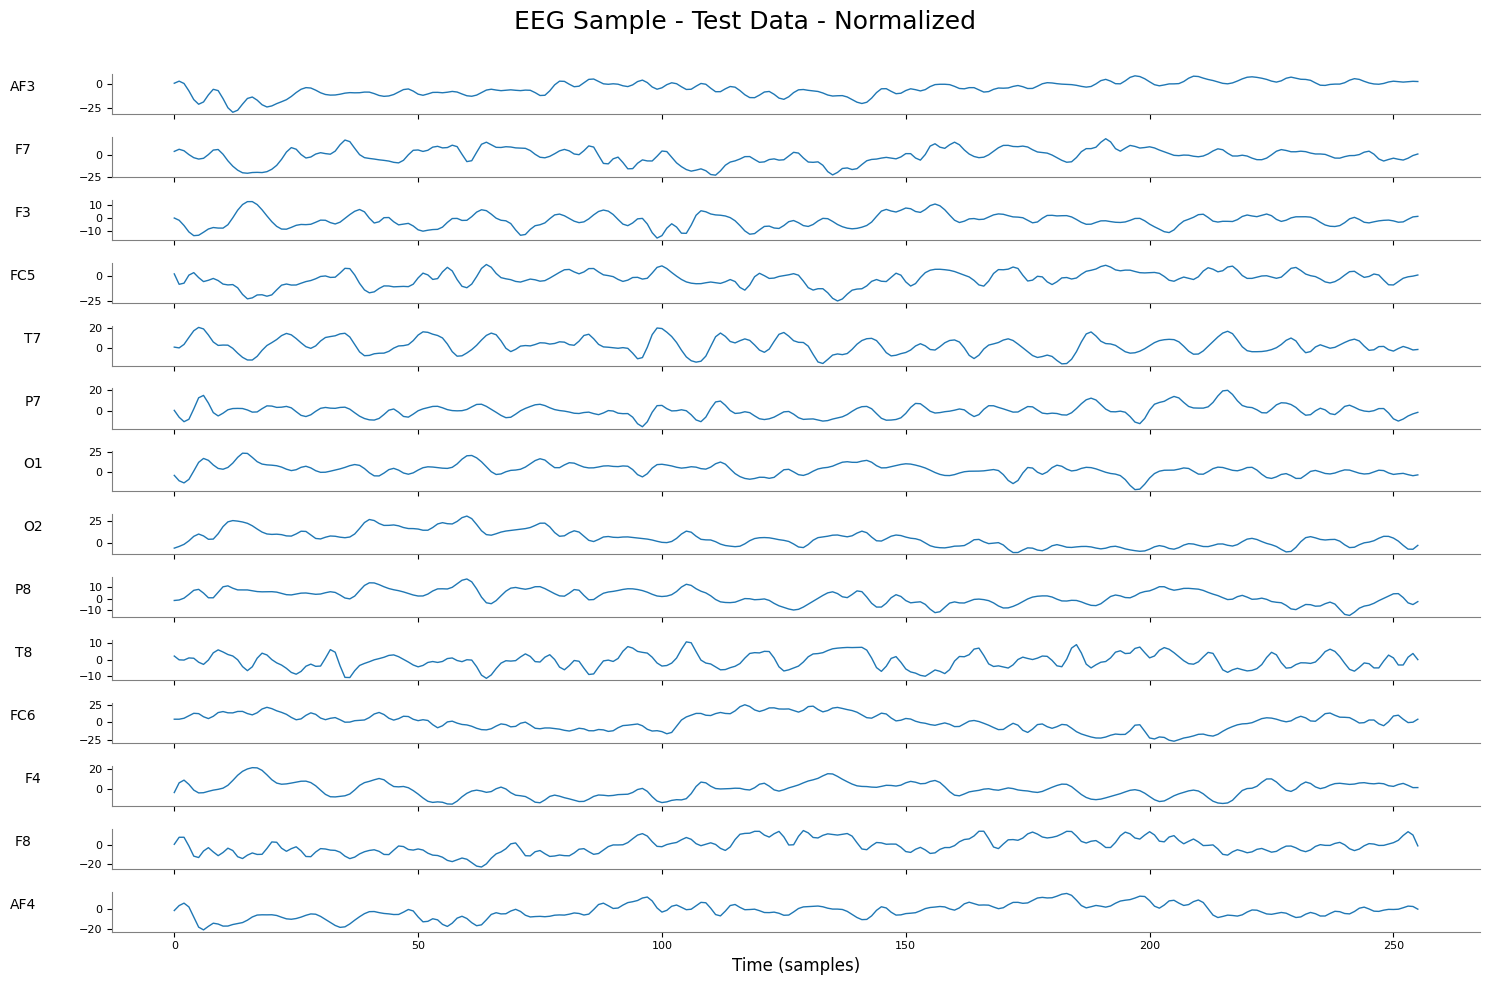

In [15]:
plot_eeg_sample(X_test_processed[0], channels=unique_channels, title="EEG Sample - Test Data - Normalized")

In [48]:
def segment_eeg_with_sliding_window(X, y, window_size=32, step=4):
    """
    Segment EEG data into overlapping windows.

    Parameters:
    - X: shape (N, C, T)
    - y: shape (N,)
    Returns:
    - X_seg: (N_segments, C, window_size)
    - y_seg: (N_segments,)
    """
    N, C, T = X.shape
    X_seg = []
    y_seg = []

    for i in range(N):
        for start in range(0, T - window_size + 1, step):
            segment = X[i, :, start:start + window_size]
            X_seg.append(segment)
            y_seg.append(y[i])

    return np.stack(X_seg), np.array(y_seg)

In [49]:
X_train_seg, y_train_seg = segment_eeg_with_sliding_window(X_train_processed, y_train_processed, window_size=32, step=4)
X_test_seg, y_test_seg = segment_eeg_with_sliding_window(X_test_processed, y_test_processed, window_size=32, step=4)

# Final shapes
print("Train:", X_train_seg.shape)
print("Test: ", X_test_seg.shape)

Train: (9462, 14, 32)
Test:  (1995, 14, 32)


In [50]:
class EEG_CNN(nn.Module):
    def __init__(self, num_channels=14, time_points=256, num_classes=10):
        super(EEG_CNN, self).__init__()
        
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Calculate the final flattened size after conv + pooling
        self.flattened_size = (time_points // 2) * 64
        
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # x: (batch, channels, time)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # (batch, 64, time/2)
        
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [51]:
# Convert train and test sets to tensors
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_processed, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_processed, dtype=torch.long)

# Create Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model, loss, optimizer
model = EEG_CNN(num_channels=14, num_classes=2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training + Evaluation loop
for epoch in range(1, 101):
    # ======== Train ========
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == batch_y).sum().item()
        total_train += batch_y.size(0)
    
    # ======== Evaluate ========
    model.eval()
    total_test_loss = 0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == batch_y).sum().item()
            total_test += batch_y.size(0)
    
    train_acc = correct_train / total_train
    test_acc = correct_test / total_test
    
    print(f"Epoch {epoch:03d}: "
          f"Train Loss = {total_train_loss:.4f}, "
          f"Train Acc = {train_acc:.2%} | "
          f"Test Loss = {total_test_loss:.4f}, "
          f"Test Acc = {test_acc:.2%}")

Epoch 001: Train Loss = 6.2141, Train Acc = 50.00% | Test Loss = 1.0386, Test Acc = 31.43%
Epoch 002: Train Loss = 2.7068, Train Acc = 51.81% | Test Loss = 0.7663, Test Acc = 68.57%
Epoch 003: Train Loss = 2.1566, Train Acc = 64.46% | Test Loss = 0.7785, Test Acc = 34.29%
Epoch 004: Train Loss = 1.8115, Train Acc = 58.43% | Test Loss = 0.6605, Test Acc = 57.14%
Epoch 005: Train Loss = 1.4433, Train Acc = 75.30% | Test Loss = 0.6665, Test Acc = 68.57%
Epoch 006: Train Loss = 1.2153, Train Acc = 78.92% | Test Loss = 0.7587, Test Acc = 45.71%
Epoch 007: Train Loss = 1.0802, Train Acc = 92.17% | Test Loss = 0.7097, Test Acc = 54.29%
Epoch 008: Train Loss = 0.8147, Train Acc = 94.58% | Test Loss = 0.6974, Test Acc = 62.86%
Epoch 009: Train Loss = 0.7545, Train Acc = 92.77% | Test Loss = 0.7639, Test Acc = 51.43%
Epoch 010: Train Loss = 0.5728, Train Acc = 98.19% | Test Loss = 0.8223, Test Acc = 54.29%
Epoch 011: Train Loss = 0.4392, Train Acc = 98.80% | Test Loss = 0.7967, Test Acc = 60.00%